In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sqliGoT import sqliGoT
from info_gain_matrix import info_gain_matrix

In [2]:
df = pd.read_csv("./resource/Modified_SQL_Dataset.csv")
X = df['Query']
y = df['Label']

print("Converting queries(undirected):")
X_sqliGoT_undirected = sqliGoT(X, windows_size = 5, type = "undirected", mode = "proportional")
X_sqliGoT_undirected = pd.DataFrame(X_sqliGoT_undirected).loc[:,(X_sqliGoT_undirected != 0).any(axis=0)].values
print("Generating information gain array:")
info_gain_arr_undirected = info_gain_matrix(X_sqliGoT_undirected, y.values)

print("Converting queries(indegree):")
X_sqliGoT_indegree = sqliGoT(X, windows_size = 5, type = "directed", mode = "proportional", degree="in")
X_sqliGoT_indegree = pd.DataFrame(X_sqliGoT_indegree).loc[:,(X_sqliGoT_indegree != 0).any(axis=0)].values
print("Generating information gain array:")
info_gain_arr_indegree = info_gain_matrix(X_sqliGoT_indegree, y.values)

print("Converting queries(outdegree):")
X_sqliGoT_outdegree = sqliGoT(X, windows_size = 5, type = "directed", mode = "proportional", degree="out")
X_sqliGoT_outdegree = pd.DataFrame(X_sqliGoT_outdegree).loc[:,(X_sqliGoT_outdegree != 0).any(axis=0)].values
print("Generating information gain array:")
info_gain_arr_outdegree = info_gain_matrix(X_sqliGoT_outdegree, y.values)


Converting queries(undirected):


100%|██████████| 30919/30919 [04:22<00:00, 117.89it/s]


Generating information gain array:


100%|██████████| 400/400 [00:09<00:00, 41.07it/s]


Converting queries(indegree):


100%|██████████| 30919/30919 [02:50<00:00, 181.53it/s]


Generating information gain array:


100%|██████████| 400/400 [00:08<00:00, 46.79it/s]


Converting queries(outdegree):


100%|██████████| 30919/30919 [02:54<00:00, 176.78it/s]


Generating information gain array:


100%|██████████| 399/399 [00:08<00:00, 47.11it/s]


In [4]:
size = 5

while(size<=400):
    indices_undirected = info_gain_arr_undirected.argsort()[-size:]
    X_sqliGoT_undirected_tmp = np.take(X_sqliGoT_undirected, indices_undirected, axis=1)
    indices_indegree = info_gain_arr_indegree.argsort()[-size:]
    X_sqliGoT_indegree_tmp = np.take(X_sqliGoT_indegree, indices_indegree, axis=1)
    indices_outdegree = info_gain_arr_outdegree.argsort()[-size:]
    X_sqliGoT_outdegree_tmp = np.take(X_sqliGoT_outdegree, indices_outdegree, axis=1)

    X_undirected_train, X_undirected_test, y_train, y_test = train_test_split(X_sqliGoT_undirected_tmp, y, test_size = 0.2, random_state=43192)
    X_indegree_train, X_indegree_test, y_train, y_test = train_test_split(X_sqliGoT_indegree_tmp, y, test_size = 0.2, random_state=43192)
    X_outdegree_train, X_outdegree_test, y_train, y_test = train_test_split(X_sqliGoT_outdegree_tmp, y, test_size = 0.2, random_state=43192)

    acc_score_undirected = 0
    acc_score_indegree = 0
    acc_score_outdegree = 0
    acc_score_vote = 0

    for i in range(10):
        lsvc_undirected_clf = LinearSVC(dual=False, loss='squared_hinge', C=1.0)
        lsvc_undirected_clf.fit(X_undirected_train, y_train)
        y_undirected_pred = lsvc_undirected_clf.predict(X_undirected_test)
        acc_score_undirected += accuracy_score(y_undirected_pred, y_test)

        lsvc_indegree_clf = LinearSVC(dual=False, loss='squared_hinge', C=1.0)
        lsvc_indegree_clf.fit(X_indegree_train, y_train)
        y_indegree_pred = lsvc_indegree_clf.predict(X_indegree_test)
        acc_score_indegree += accuracy_score(y_indegree_pred, y_test)

        lsvc_outdegree_clf = LinearSVC(dual=False, loss='squared_hinge', C=1.0)
        lsvc_outdegree_clf.fit(X_outdegree_train, y_train)
        y_outdegree_pred = lsvc_outdegree_clf.predict(X_outdegree_test)
        acc_score_outdegree += accuracy_score(y_outdegree_pred, y_test)

        y_vote_pred = y_undirected_pred + y_indegree_pred + y_outdegree_pred
        for i in range(len(y_vote_pred)):
            if y_vote_pred[i] <= 1:
                y_vote_pred[i] = 0
            else:
                y_vote_pred[i] = 1
        acc_score_vote += accuracy_score(y_vote_pred, y_test)

    acc_score_undirected /= 10
    pd.DataFrame([acc_score_undirected]).to_csv("./data_info_undirected.csv", header = False, index = False, mode = 'a')
    acc_score_indegree /= 10
    pd.DataFrame([acc_score_indegree]).to_csv("./data_info_indegree.csv", header = False, index = False, mode = 'a')
    acc_score_outdegree /= 10
    pd.DataFrame([acc_score_outdegree]).to_csv("./data_info_outdegree.csv", header = False, index = False, mode = 'a')
    acc_score_vote /= 10
    pd.DataFrame([acc_score_vote]).to_csv("./data_info_vote.csv", header = False, index = False, mode = 'a')

    size += 5


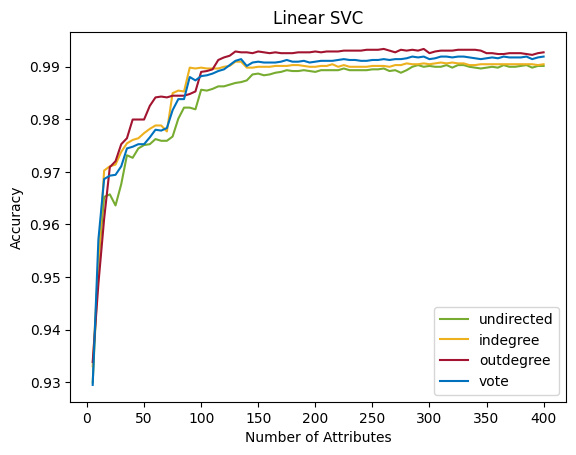

In [30]:
undirected = pd.read_csv("./data_info_undirected.csv").values
indegree = pd.read_csv("./data_info_indegree.csv").values
outdegree = pd.read_csv("./data_info_outdegree.csv").values
vote = pd.read_csv("./data_info_vote.csv").values
index = np.arange(5,405,5)
plt.plot(index, undirected, color = "#77AC30", label = "undirected")
plt.plot(index, indegree, color = "#EDB120", label = "indegree")
plt.plot(index, outdegree, color = "#A2142F", label = "outdegree")
plt.plot(index, vote, color = "#0072BD", label = "vote")

plt.legend()
plt.title("Linear SVC")
plt.xlabel("Number of Attributes")
plt.ylabel("Accuracy")

plt.show()

In [31]:
size = 5

while(size<=400):
    indices_undirected = info_gain_arr_undirected.argsort()[-size:]
    X_sqliGoT_undirected_tmp = np.take(X_sqliGoT_undirected, indices_undirected, axis=1)
    indices_indegree = info_gain_arr_indegree.argsort()[-size:]
    X_sqliGoT_indegree_tmp = np.take(X_sqliGoT_indegree, indices_indegree, axis=1)
    indices_outdegree = info_gain_arr_outdegree.argsort()[-size:]
    X_sqliGoT_outdegree_tmp = np.take(X_sqliGoT_outdegree, indices_outdegree, axis=1)

    X_undirected_train, X_undirected_test, y_train, y_test = train_test_split(X_sqliGoT_undirected_tmp, y, test_size = 0.2, random_state=43192)
    X_indegree_train, X_indegree_test, y_train, y_test = train_test_split(X_sqliGoT_indegree_tmp, y, test_size = 0.2, random_state=43192)
    X_outdegree_train, X_outdegree_test, y_train, y_test = train_test_split(X_sqliGoT_outdegree_tmp, y, test_size = 0.2, random_state=43192)

    acc_score_undirected = 0
    acc_score_indegree = 0
    acc_score_outdegree = 0
    acc_score_vote = 0

    for i in range(10):
        rm_undirected_clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1)
        rm_undirected_clf.fit(X_undirected_train, y_train)
        y_undirected_pred = rm_undirected_clf.predict(X_undirected_test)
        acc_score_undirected += accuracy_score(y_undirected_pred, y_test)

        rm_indegree_clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1)
        rm_indegree_clf.fit(X_indegree_train, y_train)
        y_indegree_pred = rm_indegree_clf.predict(X_indegree_test)
        acc_score_indegree += accuracy_score(y_indegree_pred, y_test)

        rm_outdegree_clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1)
        rm_outdegree_clf.fit(X_outdegree_train, y_train)
        y_outdegree_pred = rm_outdegree_clf.predict(X_outdegree_test)
        acc_score_outdegree += accuracy_score(y_outdegree_pred, y_test)

        y_vote_pred = y_undirected_pred + y_indegree_pred + y_outdegree_pred
        for i in range(len(y_vote_pred)):
            if y_vote_pred[i] <= 1:
                y_vote_pred[i] = 0
            else:
                y_vote_pred[i] = 1
        acc_score_vote += accuracy_score(y_vote_pred, y_test)

    acc_score_undirected /= 10
    pd.DataFrame([acc_score_undirected]).to_csv("./data_info_undirected.csv", header = False, index = False, mode = 'a')
    acc_score_indegree /= 10
    pd.DataFrame([acc_score_indegree]).to_csv("./data_info_indegree.csv", header = False, index = False, mode = 'a')
    acc_score_outdegree /= 10
    pd.DataFrame([acc_score_outdegree]).to_csv("./data_info_outdegree.csv", header = False, index = False, mode = 'a')
    acc_score_vote /= 10
    pd.DataFrame([acc_score_vote]).to_csv("./data_info_vote.csv", header = False, index = False, mode = 'a')

    size += 5


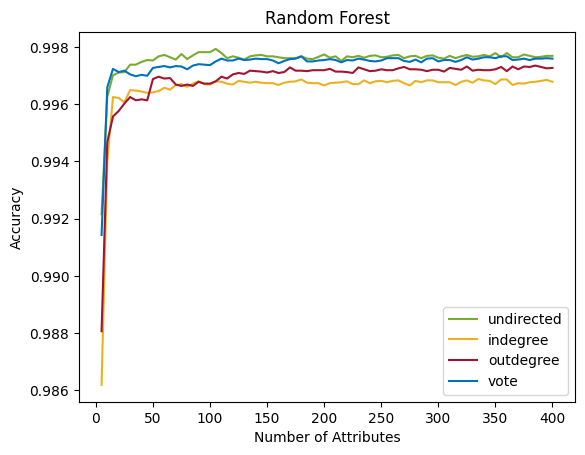

In [34]:
undirected = pd.read_csv("./data_info_undirected.csv").values
indegree = pd.read_csv("./data_info_indegree.csv").values
outdegree = pd.read_csv("./data_info_outdegree.csv").values
vote = pd.read_csv("./data_info_vote.csv").values
index = np.arange(5,405,5)
plt.plot(index, undirected, color = "#77AC30", label = "undirected")
plt.plot(index, indegree, color = "#EDB120", label = "indegree")
plt.plot(index, outdegree, color = "#A2142F", label = "outdegree")
plt.plot(index, vote, color = "#0072BD", label = "vote")

plt.legend()
plt.title("Random Forest")
plt.xlabel("Number of Attributes")
plt.ylabel("Accuracy")

plt.show()